In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import hashlib
%matplotlib inline

In [2]:
prediction_folder = '/mnt/vdc/kuba/RESULTS/TGN_memory3_experiment_trace_0to210/TGN/ckpt/'
model_name = 'TGN_without_memory_trace'
ground_truth_path = '/home/jreha/jakub-reha/darpa_labelling/groundtruth/'
conf_id = '0'
dataset = 'TRACE'
dataset_path = '/home/jreha/data/parsed_for_training/darpa_trace_0to210'

In [3]:
nodes = pd.read_csv(os.path.join(dataset_path, "attributed_nodes.csv"))
nodes = nodes.drop(columns=["Unnamed: 0"])
edges = pd.read_csv(os.path.join(dataset_path, "edges.csv"))
if dataset == 'TRACE':
    split = "0to210"
    firefox_backdoor = pd.read_csv(os.path.join(ground_truth_path,"TC3_trace_firefox_backdoor_final_aggregated.csv"))
    browser_extension = pd.read_csv(os.path.join(ground_truth_path,"TC3_trace_browser_extension_final_aggregated.csv"))
    pine_phishing_exe = pd.read_csv(os.path.join(ground_truth_path,"TC3_trace_pine_phishing_exe_final_aggregated.csv"))
    trace_thunderbird_phishing_exe = pd.read_csv(os.path.join(ground_truth_path,"TC3_trace_thunderbird_phishing_exe_final_aggregated.csv"))
    attacks = pd.concat([firefox_backdoor, browser_extension, pine_phishing_exe, trace_thunderbird_phishing_exe])
elif dataset == 'THEIA':
    split = "0to25"
    firefox_backdoor = pd.read_csv(os.path.join(ground_truth_path,"TC3_theia_firefox_backdoor_final_aggregated.csv"))
    browser_extension = pd.read_csv(os.path.join(ground_truth_path,"TC3_theia_browser_extension_final_aggregated.csv"))
    attacks = pd.concat([firefox_backdoor, browser_extension])
else:
    raise NotImplemented

edges["malicious"] = False
edges.loc[edges.hash_id.isin(attacks.edge_hash_id), "malicious"] = True

/tmp/ipykernel_1442393/2658468463.py:1: DtypeWarning: Columns (2,3,5,6,7,10,12,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  nodes = pd.read_csv(os.path.join(dataset_path, "attributed_nodes.csv"))


In [4]:
n_seeds = 5
aggregated_predictions = 0
for seed in range(0, n_seeds):
    prediction_path = os.path.join(prediction_folder, f"split_conf_{conf_id}_detection_results-{split}_seed_{seed}.csv")
    predictions = pd.read_csv(prediction_path)
    aggregated_predictions += predictions.prob.values
aggregated_predictions /= n_seeds

In [5]:
mask = ~aggregated_predictions.round().astype(bool)

In [6]:
#edges
src = nodes.iloc[edges.src.values]
dst = nodes.iloc[edges.dst.values]
for k in src:
    edges[k+"_src"] = src[k].values

for k in dst:
    edges[k+"_dst"] = dst[k].values

In [7]:
fp = edges[edges.ext_roll == 2][mask & (~edges[edges.ext_roll == 2].malicious)]
tn = edges[edges.ext_roll == 2][~mask & (~edges[edges.ext_roll == 2].malicious)]
tp = edges[edges.ext_roll == 2][mask & (edges[edges.ext_roll == 2].malicious)]
fn = edges[edges.ext_roll == 2][~mask & (edges[edges.ext_roll == 2].malicious)]
train = edges[edges.ext_roll == 0]

In [8]:
tp

,Unnamed: 0,hash_id,src,dst,syscall,sequence,session,time,file,ext_roll,...,root_class_dst,pid_dst,exe_dst,ppid_dst,args_dst,processes_class_dst,ip_dst,port_dst,private_dst,port_class_dst
8061212,9905835,-7383664851556045606,5148058,1790107,8,1685786081,0,668208759.0,125,2,...,NaN,26254.0,firefox,26253.0,firefox,9.0,NaN,NaN,NaN,NaN
8061215,9905838,7508870628210231522,1789838,5148058,9,1685786104,0,668208827.0,125,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2.233.33.53,80.0,0.0,"[2.0, 12]"
8061229,9905867,3582250241417735870,1789839,5148058,9,1685786720,0,668211231.0,125,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2.233.33.53,80.0,0.0,"[2.0, 12]"
8061245,9905896,-4840542037467638471,1789837,5148058,9,1685789441,0,668214131.0,125,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2.233.33.53,80.0,0.0,"[2.0, 12]"
8061524,9906464,9080126294131696396,1795014,5148058,9,1686770886,0,668273604.0,125,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2.233.33.53,80.0,0.0,"[2.0, 12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9893043,12419468,-5941880719995484593,6106238,2017642,8,182258924,0,940422344.0,208,2,...,NaN,27201.0,tcexec,27183.0,tcexec,20.0,NaN,NaN,NaN,NaN
9893044,12419469,5180424747574498189,2017642,6106238,9,182258926,0,940422344.0,208,2,...,NaN,NaN,NaN,NaN,NaN,NaN,162.66.239.75,80.0,0.0,"[2.0, 12]"
9893056,12419488,6145333835949169569,6106238,2017642,8,182258951,0,940428412.0,208,2,...,NaN,27201.0,tcexec,27183.0,tcexec,20.0,NaN,NaN,NaN,NaN
9893057,12419489,-1585340478009656848,2017642,6106238,9,182258953,0,940428412.0,208,2,...,NaN,NaN,NaN,NaN,NaN,NaN,162.66.239.75,80.0,0.0,"[2.0, 12]"


In [9]:
columns_to_group = ['type_src','type_dst','syscall', 'exe_src', 'exe_dst']
splits = [fn, tn, tp, fp, train]
fn_bar, tn_bar, tp_bar, fp_bar, train_bar = [x.groupby(columns_to_group, dropna=False).size() for x in splits]
keys = list(set(tn_bar.index).union(set(tp_bar.index)).union(set(fp_bar.index)).union(set(fn_bar.index)).union(set(train_bar.index)))

In [10]:
def plot_hist(group1, group2, name1, name2, keys):
    N = len(keys)
    ind = np.arange(N)
    width = 0.35 
    values1 = np.array([group1.values[list(group1.index).index(k)] if k in group1.index else 0 for k in keys])
    if group2 is not None:
        values2 = np.array([group2.values[list(group2.index).index(k)] if k in group2.index else 0 for k in keys])
    plt.figure()
    plt.bar(ind, values1/values1.sum(), width, label=name1)
    if group2 is not None:
        plt.bar(ind + width, values2/values2.sum(), width, label=name2)
    plt.xticks(ind + width / 2, [str(i) for i in keys], rotation=90)
    plt.legend()
    plt.show()

In [11]:
fp.columns

Index(['Unnamed: 0', 'hash_id', 'src', 'dst', 'syscall', 'sequence', 'session',
       'time', 'file', 'ext_roll', 'src_ip', 'dst_ip', 'port', 'groups',
       'malicious', 'n_id_src', 'name_src', 'version_src', 'type_src',
       'extension_src', 'extensions_class_src', 'root_src', 'root_class_src',
       'pid_src', 'exe_src', 'ppid_src', 'args_src', 'processes_class_src',
       'ip_src', 'port_src', 'private_src', 'port_class_src', 'n_id_dst',
       'name_dst', 'version_dst', 'type_dst', 'extension_dst',
       'extensions_class_dst', 'root_dst', 'root_class_dst', 'pid_dst',
       'exe_dst', 'ppid_dst', 'args_dst', 'processes_class_dst', 'ip_dst',
       'port_dst', 'private_dst', 'port_class_dst'],
      dtype='object')

In [12]:
fp_bar.sort_values(ascending=False)[:10]/fp_bar.sort_values(ascending=False).sum()*100

type_src  type_dst  syscall  exe_src  exe_dst
1         0         15       firefox  NaN        32.614809
                    7        firefox  NaN        23.072129
          2         16       firefox  NaN         9.664121
0         1         14       NaN      firefox     8.315490
1         2         9        firefox  NaN         6.580167
          0         6        rm       NaN         4.119395
                             firefox  NaN         3.205395
2         1         8        NaN      firefox     2.847464
1         0         15       wget     NaN         1.633057
                    7        wget     NaN         1.629862
dtype: float64

In [13]:
tn_bar.sort_values(ascending=False)[:10]/tn_bar.sort_values(ascending=False).sum()*100

type_src  type_dst  syscall  exe_src      exe_dst     
0         1         14       NaN          firefox         36.277590
2         1         8        NaN          avahi-daemon    18.477383
                                          firefox          6.647326
0         1         14       NaN          top              3.218908
1         0         15       firefox      NaN              3.181044
0         1         14       NaN          apt-config       2.761927
                    8        NaN          dbus-daemon      2.070916
1         0         9        dbus-daemon  NaN              2.066632
          2         16       firefox      NaN              1.793704
0         1         14       NaN          sysctl           1.743924
dtype: float64

In [14]:
train_bar.sort_values(ascending=False)[:10]/train_bar.sort_values(ascending=False).sum()*100

type_src  type_dst  syscall  exe_src      exe_dst     
0         1         14       NaN          firefox         26.372587
2         1         8        NaN          avahi-daemon    12.310007
                                          firefox         10.021463
1         0         15       firefox      NaN              4.938565
0         1         14       NaN          top              4.541430
                                          apt-config       3.538114
                                          sysctl           2.524263
1         2         16       firefox      NaN              2.373974
0         1         8        NaN          dbus-daemon      2.237916
1         0         9        dbus-daemon  NaN              2.236113
dtype: float64

In [15]:
fp.time/1000/60/60/24

8009008      7.719532
8009286      7.719532
8009324      7.719532
8009429      7.719532
8009493      7.719533
              ...    
10101405    10.997032
10101639    10.997033
10101655    10.997033
10101841    10.997033
10101882    10.997033
Name: time, Length: 62582, dtype: float64

In [16]:
plt.rcParams['lines.markersize'] ** 2

36.0

In [17]:
train.time

0                  0.0
1                  0.0
2                  0.0
3                512.0
4                692.0
              ...     
6766961    590048373.0
6766962    590048373.0
6766963    590049769.0
6766964    590050153.0
6766965    590050261.0
Name: time, Length: 6766966, dtype: float64

In [18]:
test = pd.concat([fp, tp, fn, tn])

In [19]:
test = test.sort_values('time')
len(test)

2093781

In [20]:
tn_time = tn.time / 3600000
fp_time = fp.time / 3600000
tp_time = tp.time / 3600000
fn_time = fn.time / 3600000

In [21]:
"""
fig = plt.figure(figsize=(10, 2.4))
plt.scatter(tn_time.values, np.ones(len(tn_time)), s = 0.00001, c='blue', label='_nolegend_')
plt.scatter(tp_time.values, np.ones(len(tp_time))+1, s = 0.01, c='orange', label='_nolegend_')
plt.scatter(fn_time.values, np.ones(len(fn_time))+2, s = 0.01, c='green', label='_nolegend_')
plt.scatter(fp_time.values, np.ones(len(fp_time))+3, s = 0.01, c='red', label='_nolegend_')
x = test[(test['exe_dst']=='firefox') | (test['exe_src']=='firefox')].time.values/3600000
y = np.arange(len(x)) * 3 / len(x) + 1
plt.plot(x, y, c = 'cyan', label = 'firefox cumulative activity')
plt.yticks(ticks = [1, 2, 3, 4] , labels = ["True negatives", "True positives", "False negatives", "False positves"] )
plt.xlabel("Hours")
plt.grid(axis='x', linewidth = 0.4)
plt.axvline(x=255.879113, color='black', ls='--', lw=1, label='Reboot')
plt.legend(prop={'size': 8})
plt.savefig("test_time_dist.png", dpi=1200, bbox_inches='tight')
plt.show()"""

'\nfig = plt.figure(figsize=(10, 2.4))\nplt.scatter(tn_time.values, np.ones(len(tn_time)), s = 0.00001, c=\'blue\', label=\'_nolegend_\')\nplt.scatter(tp_time.values, np.ones(len(tp_time))+1, s = 0.01, c=\'orange\', label=\'_nolegend_\')\nplt.scatter(fn_time.values, np.ones(len(fn_time))+2, s = 0.01, c=\'green\', label=\'_nolegend_\')\nplt.scatter(fp_time.values, np.ones(len(fp_time))+3, s = 0.01, c=\'red\', label=\'_nolegend_\')\nx = test[(test[\'exe_dst\']==\'firefox\') | (test[\'exe_src\']==\'firefox\')].time.values/3600000\ny = np.arange(len(x)) * 3 / len(x) + 1\nplt.plot(x, y, c = \'cyan\', label = \'firefox cumulative activity\')\nplt.yticks(ticks = [1, 2, 3, 4] , labels = ["True negatives", "True positives", "False negatives", "False positves"] )\nplt.xlabel("Hours")\nplt.grid(axis=\'x\', linewidth = 0.4)\nplt.axvline(x=255.879113, color=\'black\', ls=\'--\', lw=1, label=\'Reboot\')\nplt.legend(prop={\'size\': 8})\nplt.savefig("test_time_dist.png", dpi=1200, bbox_inches=\'tight\

In [22]:
"""fig = plt.figure(figsize=(10, 2.4))
ax = fig.add_subplot(111)
l1 = ax.scatter(tn_time.values, np.zeros(len(tn_time)), s = 0.00001, c='blue', label='_nolegend_')
l2 = ax.scatter(tp_time.values, np.zeros(len(tp_time))+0.33, s = 0.01, c='orange', label='_nolegend_')
l3 = ax.scatter(fn_time.values, np.zeros(len(fn_time))+0.67, s = 0.01, c='green', label='_nolegend_')
l4 = ax.scatter(fp_time.values, np.zeros(len(fp_time))+1, s = 0.01, c='red', label='_nolegend_')
plt.yticks(ticks = [0, 0.33, 0.67, 1] , labels = ["True negatives", "True positives", "False negatives", "False positves"] )
x = test[(test['exe_dst']=='firefox') | (test['exe_src']=='firefox')].time.values / 3600000
y = np.arange(len(x)) / len(x)
ax2 = ax.twinx()
l5 = ax2.plot(x, y, c = 'cyan', label = 'firefox cumulative activity')[0]
plt.xlabel("Hours")
ax.grid(linewidth = 0.4)
ax2.grid(linewidth = 0.4)
l6 = ax.axvline(x=255.879113, color='black', ls='--', lw=1, label='Reboot')
ls = [l1,l2,l3,l4,l5,l6]
labs = [l.get_label() for l in ls]

ax.legend(ls, labs, prop={'size': 8})
plt.savefig("test_time_dist.png", dpi=1200, bbox_inches='tight')
plt.show()"""

'fig = plt.figure(figsize=(10, 2.4))\nax = fig.add_subplot(111)\nl1 = ax.scatter(tn_time.values, np.zeros(len(tn_time)), s = 0.00001, c=\'blue\', label=\'_nolegend_\')\nl2 = ax.scatter(tp_time.values, np.zeros(len(tp_time))+0.33, s = 0.01, c=\'orange\', label=\'_nolegend_\')\nl3 = ax.scatter(fn_time.values, np.zeros(len(fn_time))+0.67, s = 0.01, c=\'green\', label=\'_nolegend_\')\nl4 = ax.scatter(fp_time.values, np.zeros(len(fp_time))+1, s = 0.01, c=\'red\', label=\'_nolegend_\')\nplt.yticks(ticks = [0, 0.33, 0.67, 1] , labels = ["True negatives", "True positives", "False negatives", "False positves"] )\nx = test[(test[\'exe_dst\']==\'firefox\') | (test[\'exe_src\']==\'firefox\')].time.values / 3600000\ny = np.arange(len(x)) / len(x)\nax2 = ax.twinx()\nl5 = ax2.plot(x, y, c = \'cyan\', label = \'firefox cumulative activity\')[0]\nplt.xlabel("Hours")\nax.grid(linewidth = 0.4)\nax2.grid(linewidth = 0.4)\nl6 = ax.axvline(x=255.879113, color=\'black\', ls=\'--\', lw=1, label=\'Reboot\')\nl

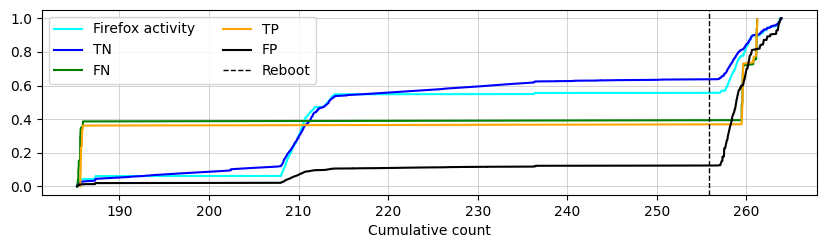

In [23]:
fig = plt.figure(figsize=(10, 2.4))
ax = fig.add_subplot(111)

x = test[(test['exe_dst']=='firefox') | (test['exe_src']=='firefox')].time.values / 3600000
y = np.arange(len(x)) / len(x)
ax.plot(x, y, c = 'cyan', label = 'Firefox activity')

for name, group, c in zip(['TN', 'FN', 'TP', 'FP'], [tn, fn, tp, fp], ['blue', 'green', 'orange', 'black']):
    x = group.time.values / 3600000
    y = np.arange(len(x)) / len(x)
    ax.plot(x, y, c=c, label = name)
plt.rcParams.update({'font.size': 10})
plt.xlabel("Hours")
plt.xlabel("Cumulative count")
ax.grid(linewidth = 0.4)
ax.axvline(x=255.879113, color='black', ls='--', lw=1, label='Reboot')
ax.legend(loc = 'upper left',prop={'size': 10}, ncol=2)
plt.savefig("test_time_dist_cum.pdf", bbox_inches='tight')
plt.show()

In [24]:
"""columns_to_group = ['type_src','type_dst', 'exe_src', 'exe_dst']
new = fp_260.groupby(columns_to_group, dropna=False).size()
new.sort_values(ascending=False)[:10]/new.sort_values(ascending=False).sum()"""

"columns_to_group = ['type_src','type_dst', 'exe_src', 'exe_dst']\nnew = fp_260.groupby(columns_to_group, dropna=False).size()\nnew.sort_values(ascending=False)[:10]/new.sort_values(ascending=False).sum()"

In [25]:
"""columns_to_group = ['type_src','type_dst', 'exe_src', 'exe_dst']
new = fp_210.groupby(columns_to_group, dropna=False).size()
new.sort_values(ascending=False)[:10]/new.sort_values(ascending=False).sum()"""

"columns_to_group = ['type_src','type_dst', 'exe_src', 'exe_dst']\nnew = fp_210.groupby(columns_to_group, dropna=False).size()\nnew.sort_values(ascending=False)[:10]/new.sort_values(ascending=False).sum()"

In [26]:
tn_bar = tn.groupby(columns_to_group, dropna=False).size()
tn_bar.sort_values(ascending=False)[0:30]

type_src  type_dst  syscall  exe_src        exe_dst        
0         1         14       NaN            firefox            736775
2         1         8        NaN            avahi-daemon       375264
                                            firefox            135003
0         1         14       NaN            top                 65374
1         0         15       firefox        NaN                 64605
0         1         14       NaN            apt-config          56093
                    8        NaN            dbus-daemon         42059
1         0         9        dbus-daemon    NaN                 41972
          2         16       firefox        NaN                 36429
0         1         14       NaN            sysctl              35418
                                            lsb_release         31384
1         0         6        firefox        NaN                 28286
          2         9        firefox        NaN                 27910
0         1         14       N

In [27]:
tp_bar = tp.groupby(columns_to_group, dropna=False).size()
tp_bar.sort_values(ascending=False)[0:30]

type_src  type_dst  syscall  exe_src      exe_dst    
1         2         9        cache        NaN            35
                             gtcache      NaN            26
                             tcexec       NaN            20
                             ztmp         NaN            15
2         1         8        NaN          tcexec          9
1         2         9        firefox      NaN             5
2         1         8        NaN          ztmp            3
0         1         14       NaN          cache           2
2         1         8        NaN          cache           2
                                          firefox         2
1         0         7        chmod        NaN             1
                             firefox      NaN             1
                             thunderbird  NaN             1
0         1         6        NaN          thunderbird     1
1         0         6        cache        NaN             1
0         1         13       NaN          ztmp

In [28]:
ids = list(tn_bar.index)
vals = list(tn_bar.values)
tn_dict = { str(ids[i]):vals[i] for i in range(len(vals))}

ids = list(fp_bar.index)
vals = list(fp_bar.values)
fp_dict = { str(ids[i]):vals[i] for i in range(len(vals))}

In [29]:
result = []
for k in fp_dict:
    if k not in tn_dict or fp_dict[k] > tn_dict[k]:
        result.append((k, fp_dict[k]))

### Most common false positives that are more common in FP than in TN

In [30]:
from pprint import pprint
result.sort(key = lambda x: x[1], reverse=True)
pprint(result[:7])

[("(1, 0, 6, 'rm', nan)", 2578),
 ("(1, 2, 15, 'pine', nan)", 210),
 ("(2, 1, 8, nan, 'pass_mgr')", 30),
 ("(1, 0, 15, 'DOM Worker', nan)", 20),
 ("(1, 0, 7, 'DOM Worker', nan)", 10),
 ("(1, 0, 7, 'dd', nan)", 9),
 ("(1, 0, 7, 'gnome-pty-helpe', nan)", 7)]


In [31]:
train_ = train[(train['exe_dst'] == 'firefox')|(train['exe_src'] == 'firefox')|(train['exe_dst'] == 'rm')|(train['exe_src'] == 'rm')]
train_bar_ = train_.groupby(columns_to_group, dropna=False).size()

In [32]:
train_bar_.sort_values(ascending=False)[0:60]

type_src  type_dst  syscall  exe_src          exe_dst        
0         1         14       NaN              firefox            1784624
2         1         8        NaN              firefox             678149
1         0         15       firefox          NaN                 334191
          2         16       firefox          NaN                 160646
                    9        firefox          NaN                 145986
          0         7        firefox          NaN                 145536
                    6        firefox          NaN                 123168
          1         2        firefox          firefox              35903
                                              Web Content           9886
          0         16       firefox          NaN                   6986
                    6        rm               NaN                   1995
          1         2        firefox          IPDL Background       1627
                    3        xfce4-appfinder  firefox         

In [34]:
import pickle
with open('10_neighbours_new.p', 'rb') as file:
    out = pickle.load(file)

In [35]:
import pickle
with open('10_neighbours_new_train.p', 'rb') as file:
    out_train = pickle.load(file)

In [36]:
fp_src_out = {}
fp_dst_out = {}
fp_out = {}
tn_out = {}

for edge in fp.hash_id:
    fp_out[edge] = out[edge]
for edge in tn.hash_id:
    tn_out[edge] = out[edge]

tn_hist = [len(tn_out[i]['src']) for i in tn_out if 'src' in tn_out[i]] + [len(tn_out[i]['dst']) for i in tn_out if 'dst' in tn_out[i]]
fp_hist = [len(fp_out[i]['src']) for i in fp_out if 'src' in fp_out[i]] + [len(fp_out[i]['dst']) for i in fp_out if 'dst' in fp_out[i]]

In [37]:
#edges["rowhash"] = edges.apply(lambda x: hashlib.md5(str(tuple(x)).encode('utf-8')).hexdigest(), axis = 1)

In [38]:
#assert len(edges["rowhash"].unique()) == len(edges)

In [39]:
#edges["rowhash"].head()

In [40]:
fp["src_n_neigh"] = fp.apply(lambda x: len(out[x.hash_id]['src']), axis = 1)
fp["dst_n_neigh"] = fp.apply(lambda x: len(out[x.hash_id]['dst']), axis = 1)

In [41]:
tn["src_n_neigh"] = tn.apply(lambda x: len(out[x.hash_id]['src']), axis = 1)
tn["dst_n_neigh"] = tn.apply(lambda x: len(out[x.hash_id]['dst']), axis = 1)

In [42]:
train["src_n_neigh"] = train.apply(lambda x: len(out_train[x.hash_id]['src']), axis = 1)
train["dst_n_neigh"] = train.apply(lambda x: len(out_train[x.hash_id]['dst']), axis = 1)

/tmp/ipykernel_1442393/1016487138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["src_n_neigh"] = train.apply(lambda x: len(out_train[x.hash_id]['src']), axis = 1)
/tmp/ipykernel_1442393/1016487138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["dst_n_neigh"] = train.apply(lambda x: len(out_train[x.hash_id]['dst']), axis = 1)


In [43]:
len(fp)

62582

In [44]:
columns_to_group = ['type_src','type_dst','syscall', 'exe_src', 'exe_dst']
nn = fp.groupby(columns_to_group, dropna=False).agg({"src_n_neigh": np.mean, "dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False)
((nn / nn.sum())[:10]*100).round(decimals=1)

src_n_neigh  dst_n_neigh  hash_id
type_src type_dst syscall exe_src exe_dst                                   
1        0        15      firefox NaN              0.7          0.5     32.6
                  7       firefox NaN              0.8          0.5     23.1
         2        16      firefox NaN              0.5          0.6      9.7
0        1        14      NaN     firefox          0.8          1.1      8.3
1        2        9       firefox NaN              0.0          1.0      6.6
         0        6       rm      NaN              1.3          0.6      4.1
                          firefox NaN              0.5          0.4      3.2
2        1        8       NaN     firefox          0.0          0.0      2.8
1        0        15      wget    NaN              0.9          0.3      1.6
                  7       wget    NaN              0.9          0.3      1.6

In [45]:
columns_to_group = ['type_src','type_dst','syscall', 'exe_src', 'exe_dst']
nn = tn.groupby(columns_to_group, dropna=False).agg({"src_n_neigh": np.mean, "dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False).round(decimals=1)
((nn / nn.sum())[:20]*100).round(decimals=1)

src_n_neigh  \
type_src type_dst syscall exe_src     exe_dst                        
0        1        14      NaN         firefox                  0.2   
2        1        8       NaN         avahi-daemon             0.0   
                                      firefox                  0.0   
0        1        14      NaN         top                      0.1   
1        0        15      firefox     NaN                      0.3   
0        1        14      NaN         apt-config               0.5   
                  8       NaN         dbus-daemon              0.1   
1        0        9       dbus-daemon NaN                      0.0   
         2        16      firefox     NaN                      0.1   
0        1        14      NaN         sysctl                   0.2   
                                      lsb_release              0.5   
1        0        6       firefox     NaN                      0.2   
         2        9       firefox     NaN                      0.0   
0        1        14      NaN         sshd                     0.4   
                                      xfce4-appfinder          0.3   
                                      bash                     0.2   
1        0        7       firefox     NaN                      0.3   
0        1        14      NaN         cargo                    0.4   
                                      thunderbird              0.3   
                                      dpkg                     0.5   

                                                       dst_n_neigh  hash_id  
type_src type_dst syscall exe_src     exe_dst                                
0        1        14      NaN         firefox                  0.7     36.3  
2        1        8       NaN         avahi-daemon             1.4     18.5  
                                      firefox                  0.2      6.6  
0        1        14      NaN         top                      1.3      3.2  
1        0        15      firefox     NaN                      0.1      3.2  
0        1        14      NaN         apt-config               0.1      2.8  
                  8       NaN         dbus-daemon              0.1      2.1  
1        0        9       dbus-daemon NaN                      0.2      2.1  
         2        16      firefox     NaN                      0.0      1.8  
0        1        14      NaN         sysctl                   1.2      1.7  
                                      lsb_release              0.2      1.5  
1        0        6       firefox     NaN                      0.1      1.4  
         2        9       firefox     NaN                      0.0      1.4  
0        1        14      NaN         sshd                     0.4      1.2  
                                      xfce4-appfinder          0.5      1.2  
                                      bash                     0.8      1.2  
1        0        7       firefox     NaN                      0.0      1.2  
0        1        14      NaN         cargo                    0.1      1.1  
                                      thunderbird              0.9      0.9  
                                      dpkg                     0.0      0.8

In [46]:
columns_to_group = ['type_src','type_dst','syscall', 'exe_src', 'exe_dst']
nn = train.groupby(columns_to_group, dropna=False).agg({"src_n_neigh": np.mean, "dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False).round(decimals=1)[:20]
((nn / nn.sum())[:20]*100).round(decimals=1)

src_n_neigh  \
type_src type_dst syscall exe_src     exe_dst                        
0        1        14      NaN         firefox                  4.2   
2        1        8       NaN         avahi-daemon             0.0   
                                      firefox                  3.0   
1        0        15      firefox     NaN                      6.5   
0        1        14      NaN         top                      2.3   
                                      apt-config              10.2   
                                      sysctl                   5.0   
1        2        16      firefox     NaN                      2.7   
0        1        8       NaN         dbus-daemon              1.4   
1        0        9       dbus-daemon NaN                      1.0   
         2        9       firefox     NaN                      0.1   
         0        7       firefox     NaN                      6.7   
0        1        14      NaN         xfce4-appfinder          7.9   
1        0        6       firefox     NaN                      4.9   
0        1        14      NaN         sshd                     8.9   
                                      bash                     4.9   
                                      lsb_release             10.1   
                                      cargo                    9.9   
2        1        8       NaN         Socket Thread            0.0   
0        1        14      NaN         dpkg                    10.2   

                                                       dst_n_neigh  hash_id  
type_src type_dst syscall exe_src     exe_dst                                
0        1        14      NaN         firefox                  7.5     30.1  
2        1        8       NaN         avahi-daemon            15.2     14.1  
                                      firefox                  2.0     11.4  
1        0        15      firefox     NaN                      0.9      5.6  
0        1        14      NaN         top                     14.8      5.2  
                                      apt-config               1.2      4.0  
                                      sysctl                  13.7      2.9  
1        2        16      firefox     NaN                      0.0      2.7  
0        1        8       NaN         dbus-daemon              1.5      2.6  
1        0        9       dbus-daemon NaN                      2.1      2.6  
         2        9       firefox     NaN                      2.9      2.5  
         0        7       firefox     NaN                      0.0      2.5  
0        1        14      NaN         xfce4-appfinder          5.6      2.3  
1        0        6       firefox     NaN                      1.4      2.1  
0        1        14      NaN         sshd                     4.7      1.8  
                                      bash                     9.1      1.7  
                                      lsb_release              2.6      1.7  
                                      cargo                    1.8      1.6  
2        1        8       NaN         Socket Thread           12.5      1.4  
0        1        14      NaN         dpkg                     0.3      1.3

In [62]:
train.columns

Index(['Unnamed: 0', 'hash_id', 'src', 'dst', 'syscall', 'sequence', 'session',
       'time', 'file', 'ext_roll', 'src_ip', 'dst_ip', 'port', 'groups',
       'malicious', 'n_id_src', 'name_src', 'version_src', 'type_src',
       'extension_src', 'extensions_class_src', 'root_src', 'root_class_src',
       'pid_src', 'exe_src', 'ppid_src', 'args_src', 'processes_class_src',
       'ip_src', 'port_src', 'private_src', 'port_class_src', 'n_id_dst',
       'name_dst', 'version_dst', 'type_dst', 'extension_dst',
       'extensions_class_dst', 'root_dst', 'root_class_dst', 'pid_dst',
       'exe_dst', 'ppid_dst', 'args_dst', 'processes_class_dst', 'ip_dst',
       'port_dst', 'private_dst', 'port_class_dst', 'src_n_neigh',
       'dst_n_neigh'],
      dtype='object')

In [63]:
columns_to_group = ['type_dst', 'private_dst', 'port_class_dst']
nn = train[train.exe_src=='firefox'].groupby(columns_to_group, dropna=False).agg({"src_n_neigh": np.mean, "dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False).round(decimals=1)[:20]
((nn / nn.sum())[:20]*100).round(decimals=1)

src_n_neigh  dst_n_neigh  hash_id
type_dst private_dst port_class_dst                                   
0        NaN         NaN                    22.6         11.3     63.2
2        0.0         [2.0, 12]               0.0         22.6     25.0
                     [1.0, 12]              29.4          0.0      5.7
1        NaN         NaN                    13.6          0.0      5.1
2        0.0         [3.0, 12]               0.0          0.0      1.0
         2.0         [11.0, 12]              6.0         66.0      0.0
         0.0         [12, 6.0]              28.3          0.0      0.0

In [47]:
fn

,Unnamed: 0,hash_id,src,dst,syscall,sequence,session,time,file,ext_roll,...,root_class_dst,pid_dst,exe_dst,ppid_dst,args_dst,processes_class_dst,ip_dst,port_dst,private_dst,port_class_dst
8016374,9855918,2946712788665801714,7384,1793643,14,1670060463,0,667012819.0,125,2,...,NaN,24535.0,firefox,3619.0,firefox,9.0,NaN,NaN,NaN,NaN
8020484,9860271,5616574970314045457,7384,1793364,14,1671388446,0,667068591.0,125,2,...,NaN,24688.0,firefox,3619.0,firefox,9.0,NaN,NaN,NaN,NaN
8022538,9862692,5922800830625074234,7384,1792978,14,1672327602,0,667115532.0,125,2,...,NaN,24688.0,firefox,3619.0,firefox,9.0,NaN,NaN,NaN,NaN
8026758,9867238,3410286991386375265,7384,1794216,14,1673785823,0,667180717.0,125,2,...,NaN,24868.0,firefox,3619.0,firefox,9.0,NaN,NaN,NaN,NaN
8028718,9869554,-4777761158196626508,7384,1792393,14,1674710895,0,667225201.0,125,2,...,NaN,24868.0,firefox,3619.0,firefox,9.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9892858,12413078,4814431024008454780,2017642,6041458,16,182233737,0,940308048.0,208,2,...,NaN,NaN,NaN,NaN,NaN,NaN,103.12.253.24,80.0,0.0,"[2.0, 12]"
9892916,12413216,3168807629187335589,2017638,2026989,3,182234160,0,940338068.0,208,2,...,NaN,27388.0,uname,27201.0,uname -a,17.0,NaN,NaN,NaN,NaN
9892918,12413218,-1860745055494324681,6106238,2017642,8,182234144,0,940338068.0,208,2,...,NaN,27201.0,tcexec,27183.0,tcexec,20.0,NaN,NaN,NaN,NaN
9892921,12413221,8942822542484637964,2017642,6041355,16,182234559,0,940344396.0,208,2,...,NaN,NaN,NaN,NaN,NaN,NaN,128.55.12.1,140.0,0.0,"[10, 12.0]"


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          xcategories='auto',
                          ycategories='auto',
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:,.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        xcategories=False
        ycategories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=xcategories,yticklabels=ycategories)
    plt.rcParams.update({'font.size': 16})
    if xyplotlabels:
        plt.xlabel('True label')
        plt.ylabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

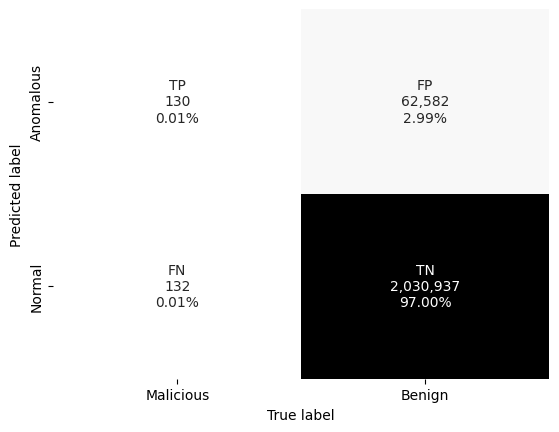

In [49]:
labels = ['TP', 'FP', 'FN', 'TN']
xcategories = ['Malicious','Benign']
ycategories = ['Anomalous','Normal']
cf_matrix = np.array([[130,62582],
                       [132, 2030937]])
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      xcategories=xcategories,
                      ycategories=ycategories, 
                      cmap='binary')
plt.savefig("conf_mat.pdf", bbox_inches='tight')

In [50]:
len(tn)

2030937

In [51]:
len(fp[(fp.exe_dst == 'firefox') | (fp.exe_src == 'firefox')])/len(fp)

0.8661755776421335

In [52]:
len(tn[(tn.exe_dst == 'firefox') | (tn.exe_src == 'firefox')])/len(tn)

0.5314399215731458

In [53]:
len(train[(train.exe_dst == 'firefox') | (train.exe_src == 'firefox')])/len(train)

0.5068515195731735

In [54]:
train

,Unnamed: 0,hash_id,src,dst,syscall,sequence,session,time,file,ext_roll,...,exe_dst,ppid_dst,args_dst,processes_class_dst,ip_dst,port_dst,private_dst,port_class_dst,src_n_neigh,dst_n_neigh
0,0,-8833939189160733874,48,496608,8,127157,0,0.0,0,0,...,init,0.0,NaN,20.0,NaN,NaN,NaN,NaN,0,0
1,1,1703741118635738530,496608,48,9,127158,0,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2,-8998476572216301191,53,496616,8,127167,0,0.0,0,0,...,dbus-daemon,1.0,NaN,20.0,NaN,NaN,NaN,NaN,0,0
3,3,-4158411197171961562,2067885,496596,8,127396,0,512.0,0,0,...,avahi-daemon,1.0,NaN,20.0,NaN,NaN,NaN,NaN,0,0
4,4,-7691119087006789968,51,496638,14,127491,0,692.0,0,0,...,sshd,6768.0,NaN,3.0,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766961,8370299,1089967517567664709,1585766,4730067,16,1345466992,0,590048373.0,109,0,...,NaN,NaN,NaN,NaN,128.55.12.10,53.0,0.0,"[1.0, 12]",9,0
6766962,8370302,2258999515868453141,1474,1585766,14,1345466988,0,590048373.0,109,0,...,Socket Thread,20085.0,firefox,20.0,NaN,NaN,NaN,NaN,7,9
6766963,8370306,464240938140924364,11731,1616753,14,1345469769,0,590049769.0,109,0,...,firefox,20070.0,firefox,9.0,NaN,NaN,NaN,NaN,9,0
6766964,8370307,-6865499190454804986,4738884,496596,8,1345486218,0,590050153.0,109,0,...,avahi-daemon,1.0,NaN,20.0,NaN,NaN,NaN,NaN,0,10


In [55]:
columns_to_group = ['type_dst', 'extension_dst', 'root_dst']
k = train[train.type_dst==0].groupby(columns_to_group, dropna=False).agg({"dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False).round(decimals=1)[:10]
k['rat'] = (k.hash_id * 100 /train[train.type_dst==0].groupby(columns_to_group, dropna=False).size().sum()).round(decimals=1)

In [56]:
k

dst_n_neigh  hash_id   rat
type_dst extension_dst root_dst                            
0        NaN           home              0.3   509396  58.1
                       var               1.6   106131  12.1
                       tmp               1.9    75460   8.6
                       dev               2.9    46850   5.3
         sbstore       home              0.1    18584   2.1
         js.tmp        home              0.0    16714   1.9
         sqlite-wal    home              4.3    15908   1.8
         json.tmp      home              0.0    14411   1.6
         js            home              0.2    10921   1.2
         bak           home              0.0     8113   0.9

In [59]:
k.to_latex()

/tmp/ipykernel_1442393/2432003049.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  k.to_latex()


'\\begin{tabular}{lllrrr}\n\\toprule\n  &     &      &  dst\\_n\\_neigh &  hash\\_id &   rat \\\\\ntype\\_dst & extension\\_dst & root\\_dst &              &          &       \\\\\n\\midrule\n0 & NaN & home &          0.3 &   509396 &  58.1 \\\\\n  &     & var &          1.6 &   106131 &  12.1 \\\\\n  &     & tmp &          1.9 &    75460 &   8.6 \\\\\n  &     & dev &          2.9 &    46850 &   5.3 \\\\\n  & sbstore & home &          0.1 &    18584 &   2.1 \\\\\n  & js.tmp & home &          0.0 &    16714 &   1.9 \\\\\n  & sqlite-wal & home &          4.3 &    15908 &   1.8 \\\\\n  & json.tmp & home &          0.0 &    14411 &   1.6 \\\\\n  & js & home &          0.2 &    10921 &   1.2 \\\\\n  & bak & home &          0.0 &     8113 &   0.9 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [67]:
columns_to_group = ['type_dst', 'private_dst', 'port_class_dst']
k = train[train.type_dst==2].groupby(columns_to_group, dropna=False).agg({"dst_n_neigh": np.mean, "hash_id": 'size'}).sort_values(by="hash_id", ascending=False).round(decimals=1)[:10]
k['rat'] = (k.hash_id * 100 /train[train.type_dst==2].groupby(columns_to_group, dropna=False).size().sum()).round(decimals=1)

In [70]:
k

dst_n_neigh  hash_id   rat
type_dst private_dst port_class_dst                            
2        0.0         [2.0, 12]               1.2   241385  64.9
                     [1.0, 12]               0.0   103635  27.9
                     [3.0, 12]               0.0    10060   2.7
                     [8.0, 12]               0.9     7357   2.0
         1.0         [12, 5.0]               0.0     2191   0.6
         0.0         [10.0]                  0.9     2020   0.5
                     [11.0]                  0.9     1467   0.4
         2.0         [11.0, 12]              0.4     1270   0.3
         1.0         [4.0, 12]               0.0     1169   0.3
         0.0         [0.0, 10]               0.0      675   0.2

In [69]:
k.to_latex()

/tmp/ipykernel_1442393/2432003049.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  k.to_latex()


'\\begin{tabular}{lllrrr}\n\\toprule\n  &     &           &  dst\\_n\\_neigh &  hash\\_id &   rat \\\\\ntype\\_dst & private\\_dst & port\\_class\\_dst &              &          &       \\\\\n\\midrule\n2 & 0.0 & [2.0, 12] &          1.2 &   241385 &  64.9 \\\\\n  &     & [1.0, 12] &          0.0 &   103635 &  27.9 \\\\\n  &     & [3.0, 12] &          0.0 &    10060 &   2.7 \\\\\n  &     & [8.0, 12] &          0.9 &     7357 &   2.0 \\\\\n  & 1.0 & [12, 5.0] &          0.0 &     2191 &   0.6 \\\\\n  & 0.0 & [10.0] &          0.9 &     2020 &   0.5 \\\\\n  &     & [11.0] &          0.9 &     1467 &   0.4 \\\\\n  & 2.0 & [11.0, 12] &          0.4 &     1270 &   0.3 \\\\\n  & 1.0 & [4.0, 12] &          0.0 &     1169 &   0.3 \\\\\n  & 0.0 & [0.0, 10] &          0.0 &      675 &   0.2 \\\\\n\\bottomrule\n\\end{tabular}\n'